# Notebook Objective and Setup

BGG08 contains the Collaborative Filtering model.

Th CF is tested in both memory and model-based modes, on both the user's real ratings data and the synthesized data sets.

Using testing results, we select the most efficient recommendation system and make our business recommendations.

## Notebook Preparation

### Package Imports

In [1]:
import pandas as pd
import numpy as np
import requests
import regex as re
import time
import os
import gc
import json
from statistics import mean

# ignore warnings (gets rid of Pandas copy warnings)
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler#, OneHotEncoder
#from missingpy import MissForest
#from sklearn.pipeline import Pipeline
#from sklearn.compose import ColumnTransformer
#from sklearn.feature_extraction.text import TfidfTransformer

from scipy import spatial


'''
# preprocessing
from statsmodels.tsa.stattools import adfuller
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_validate, HalvingGridSearchCV, validation_curve, cross_val_score, GridSearchCV, KFold, RepeatedKFold, RandomizedSearchCV

# model tools
import statsmodels.api as sm
from statsmodels.formula.api import ols

import scipy.stats as stats
from scipy.stats import norm

from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet, GammaRegressor, HuberRegressor,  Lars, Lasso, SGDRegressor
from sklearn.linear_model import LassoLars, OrthogonalMatchingPursuit, PassiveAggressiveRegressor, PoissonRegressor, RANSACRegressor, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb'''

# scoring and algorithm selection packages
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
from sklearn.inspection import permutation_importance

# visualization packages
#import matplotlib.pyplot as plt
#import seaborn as sns
#%matplotlib inline

from surprise import KNNWithMeans, SVD, Dataset, Reader, dump, accuracy, NMF, BaselineOnly
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import KFold
from surprise.prediction_algorithms.matrix_factorization import SVD, SVDpp, NMF
from surprise.prediction_algorithms.slope_one import SlopeOne
from surprise.prediction_algorithms.co_clustering import CoClustering
from surprise.prediction_algorithms.random_pred import NormalPredictor
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise.model_selection.search import GridSearchCV

### Notebook Functions

In [1]:
def get_user_distances(user_a, all_users_ratings, user_items, v=10):
    '''
    Takes in a user and dictionary of other users and their game ratings. 
    Finds users_b who have an intersection of at least v rated items (both have rated the same v items). 
    Calculates the cosine distance between user_a and each qualifying user_b.
    Stores similarity to users_b in distance_dictionary and returns distance_dictionary.
    
    Inputs:
    user_a: The user that we are finding neighbors for
    all_users_ratings: all users in the system
    user_items: the items that user_a has rated
    v=10: number of items the users must have in common to have their distance scored and recorded
    
    Outputs:
    distance_dictionary: distance between user_a and other users with a set match
    
    '''
    
    # start a list for the user distances
    distance_dictionary = {}
    
    # for each user b in the dictionary:
    for user_b in all_users_ratings:
        
        if user_b == user_a:
            continue
        
        # get a list of the user b reviewed items
        other_user_items = list(all_users_ratings[user_b].keys())
        
        # determine the intersection of the items for user a and user b
        intersection_set = set.intersection(set(user_items), set(other_user_items))
        if len(intersection_set) > v:
            #print(str(len(intersection_set))+" between "+user_a+" and "+user_b)
        
            # make list to store each user a and user b ratings
            user_a_ratings = []
            user_b_ratings = []
        
            # for each item in the intersection set of mutually reviewed items
            for item in intersection_set:
            
                # append user a ratings for the items
                user_a_ratings.append(all_users_ratings[user_a][item])
                # append user b ratings for the items
                user_b_ratings.append(all_users_ratings[user_b][item])
            
            # calculate spatial distance between the two users    
            users_distance = spatial.distance.cosine(user_a_ratings,user_b_ratings)
        
            # append the distance to the 
            distance_dictionary[user_b] = users_distance
        
        else: continue
    
    print("Found "+str(len(distance_dictionary))+" potential neighbors in common.")
    
    return distance_dictionary

In [43]:
def get_estimated_ratings(all_users_ratings, distance_dictionary, user_mean, k=30, n=1, scaled=True):
    '''
    Takes in a distance dictionary and the user_a mean.
    Finds the k closest users
    
    Inputs: 
    all_users_ratings: dictionary of all ratings to be used, can be real or synthetic
    distance_dictionary: dictionary of distances between user_a and each qualifying user_b
    user_mean: the rating mean of user_a
    k=30: number of neighbors to consider for making ratings predictions
    n=1: number of minimum neighbors that rated a potential item for it to be recommended
    scaled=True: if using scaled ratings or actual values
    
    Outputs:
    user_predicted_ratings: Estimated item ratings for user_a
    '''
    
    # make a df from the distance dictionary and sort on distance, low to high. Take head of k
    nearest_neighbors = pd.DataFrame(distance_dictionary.values(), index=distance_dictionary.keys()).sort_values(0).head(k)
    
    # send df to lookup dictionary
    neighbors_lookup = nearest_neighbors.to_dict(orient='index')
    
    # make a dictionary to store the predicted ratings for the user
    user_predicted_ratings = {}
    
    # for each item in the game_ids,
    for item in game_id_lookup.keys():
        
        # change the item to a string, because the user dictionaries have string keys
        item = str(item)
        
        # set the number of ratings and base rating to 0 for this item
        num_ratings = 0
        base_rating = 0
        
        # for each neighbor in the user_a neighbor list,
        for neighbor in list(neighbors_lookup.keys()):
        
            # their distance weight is 1-their distance (low is better and a high correlation)
            similarity = 1- neighbors_lookup[neighbor][0]
            
            # if the item we are working on is in the neighbor's actual ratings, 
            if item in all_users_ratings[neighbor].keys():
                
                # get the neighbor's rating
                neighbor_rating = all_users_ratings[neighbor][item]
                
                # weight the rating by their distance_weight
                my_rating = neighbor_rating# * similarity
                
                # add the rating to the base_ratings score for this item
                base_rating+= my_rating
                
                # add 1 to the number of ratings for this item
                num_ratings += 1
        
        # check that this item had at least n ratings added;
        if num_ratings>=n:
            # if so, the rating to add is the base_rating/num_ratings
            total_rating = base_rating/num_ratings
            
        # if the item had <= 3 ratings added, go to the next item
        else: continue
        
        if scaled:
            # the estimated rating is the total rating + the user_a mean
            estimated_rating = total_rating + user_mean
            #print(estimated_rating)
        else:
            estimated_rating = total_rating
        
        # if the total rating ends up over 10, set it to 10 (the max)
        if estimated_rating > 10:
            estimated_rating=10
        
        # put the predicted rating in the user predictions dictionary
        user_predicted_ratings[item] = estimated_rating
    
    # print a report about the user
    total_ratings_created = len(user_predicted_ratings)
    #print("Predicted "+str(total_ratings_created)+' ratings')
        
    return user_predicted_ratings

In [46]:
def calculate_errors(actual_dictionary, user_predicted_ratings, user_mean, scaled=True):
    '''
    Takes in actual ratings and predictions
    Gets the intersection of items that user actually rated, and prediction for that item
    Gets MAE and RMSE of actuals vs predictions
    
    Inputs: 
    actual_dictionary: single user's actual ratings, use REAL ratings dictionary only
    predicted_dictionary: dictionary of single user's predicted ratings
    user_mean: user's mean rating
    scaled=True: If using scaled ratings or actual values
    
    Outputs:
    user_mae, user_rmse: user's MAE and RMSE
    
    '''
    
    y_actual = []
    y_preds = []
    
    real_rated_and_predicted = list(set.intersection(set(list(actual_dictionary.keys())), set(list(user_predicted_ratings.keys()))))
    
    for item in real_rated_and_predicted:
        if scaled:
            y_actual.append(actual_dictionary[item] + user_mean)
        else:
            y_actual.append(actual_dictionary[item])
        
        y_preds.append(user_predicted_ratings[item])  
    
    user_mae = mean_absolute_error(y_preds, y_actual)
    user_rmse = np.sqrt(mean_squared_error(y_preds, y_actual))
    
    #print(user_mae, user_rmse)
    
    return user_mae, user_rmse

In [47]:
def get_user_predictions(all_users_ratings, real_users_ratings, user_set, v=10, k=30, n=1, scaled=True):
    '''
    Gets predictions for a set of users
    
    For each user, makes a list of the user's reviewed items
    Calls on get_user_distances() to find other users with v items in common
    Calls on get_estimated_ratings() to get predictions based on k neighbors
    Gets MAE and RMSE on predictions for items user actually rated
    Stores all predictions to dictionary
    
    Inputs:
    all_users_ratings: dictionary of all ratings to be used, can be real or synthetic
    real_user_ratings: dictionary of actual ratings, use REAL ratings dictionary only
    user_set: list of users to get predictions for
    v: (optional) number of required items in the intersection of two user rating sets
        to make neighbor calculation; sends to other function
    k: (optional) nearest neighbors to consider for recommendations; sends to other function
    
    Outputs:
    global_mae, global_rmse: MAE and RMSE for the user set
    predicted_ratings: dictionary of user predictions
    '''
    predicted_ratings = {}
    
    global_start = time.time()
    
    global_mae_list = []
    global_rmse_list = []
    
    for user_a in user_set:
    
        # report on user
        #print("Calculating "+user_a)
    
        # get the user's mean rating
        user_mean = user_mean_lookup[user_a]['user_mean']
    
        # make a list of the user_a reviewed items
        user_items = list(all_users_ratings[user_a].keys())
    
        # call the get_user_distances to find the user's neighbors
        distance_dictionary = get_user_distances(user_a, all_users_ratings, user_items, v)
    
        # if no neighbors were found, report and move to the next user
        if len(distance_dictionary) ==0:
            #print("Insufficient neighbors found!\n")
            continue
    
        # call get_estimated_ratings to get predictions for user_a
        user_predicted_ratings = get_estimated_ratings(all_users_ratings, distance_dictionary, user_mean, k, n, scaled)
    
        # store the predicted ratings for the user_a
        predicted_ratings[user_a] = user_predicted_ratings
    
        user_mae, user_rmse = calculate_errors(real_users_ratings[user_a], user_predicted_ratings, user_mean, scaled)
    
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        
    global_mae = mean(global_mae_list)
    global_rmse = mean(global_rmse_list)
        
    print("MAE for set of users: "+str(global_mae))
    print("RMSE for set of users: "+str(global_rmse))
        
    return global_mae, global_rmse, predicted_ratings

In [6]:
def processing_pipeline(weight_groups, df):
    '''Takes in train, validation and test sets as well as lists of the cat, cont and polynomial fields, 
    as well as a list of fields to drop. Returns processed feature sets.
    
    Inputs:
    train, val, test: feature sets for train, validation and testing
    categoricals: list of categorical features
    continuous: list of continuous features
    poly: list of features that need polynomials
    drop_fields: list of features to drop after target encoding
    
    Outputs:
    processed_train, processed_val, processed_test: fully processed inputs'''

   
    # continuous pipeline
    family_encoder = Pipeline([
        ('encoder', OneHotEncoder()),
        ('scaler', MinMaxScaler(feature_range=weight_groups[6])),
         ])
    
    # Whole pipeline with continuous then categorical transformers
    total_pipeline = ColumnTransformer([
        ('games_weight_weight', MinMaxScaler(feature_range=weight_groups[0]), ['GameWeight']),
        ('rating_weight', MinMaxScaler(feature_range=weight_groups[1]), ['AvgRating']),  
        ('bayes_weight', MinMaxScaler(feature_range=weight_groups[2]), ['BayesAvgRating']),  
        ('players_weight', MinMaxScaler(feature_range=weight_groups[3]), ['BestPlayers']),
        ('playtime_weight', MinMaxScaler(feature_range=weight_groups[4]), ['Playtime']),
        ('language_weight', MinMaxScaler(feature_range=weight_groups[5]), ['LanguageEase']),
        ('remainder_weight', MinMaxScaler(feature_range=weight_groups[6]), ['Cat:Thematic', 'Cat:Strategy', 'Cat:War',
                       'Cat:Family','Cat:CGS','Cat:Abstract','Cat:Party','Cat:Childrens']),
        #('family_encoder', family_encoder, ['Family'])
                            ]) #, sparse_threshold=0
    
    # Fit and tranform the pipeline on x_train, then transform x_test
    processed = total_pipeline.fit_transform(df)
    
    return processed


## Load Data

* real_user_ratings_dictionary_scaled: dictionary of user's real ratings for games, SCALED ratings
    * format is {user: {str(item): rating}}
    
    
* real_user_ratings_dictionary_unscaled: dictionary of user's real ratings for games, UNSCALED ratings
    * format is {user: {str(item): rating}}
    
    
* real_user_ratings_long_scaled: dataframe of melted user's real ratings for games MINUS means (SCALED)
    * format is Index : UserID : BGGId : Rating
    
    
* real_user_ratings_long_unscaled: dataframe of melted user's real ratings for games
    * format is Index : UserID : BGGId : Rating
    
    
* game_id_lookup: dictionary of game names for game ids
    * format is {id: rating}
    
    
* user_mean_lookup: dictionary of user's mean rating
    * format is {user: {'user mean':mean}}
    

* train_users, val_users, test_users
    * lists of users in train/val/test

##### Split Train/Val/Test User Lists

In [7]:
# Opening JSON file
with open('real_user_ratings_dictionary_scaled.json') as json_file:
    real_user_ratings_dictionary_scaled = json.load(json_file)

In [8]:
users_list = list(real_user_ratings_dictionary_scaled.keys())

In [9]:
del real_user_ratings_dictionary_scaled
gc.collect()

42

In [10]:
train_users, remainder = train_test_split(users_list, test_size=.1, random_state=42)
val_users, test_users = train_test_split(remainder, test_size=.5, random_state=42)

len(train_users), len(val_users), len(test_users)

(92214, 5123, 5123)

##### A little fun to get myself and friends into the validation set :)

In [11]:
'Threnody' in train_users

True

In [12]:
train_users.index('Threnody')

63406

In [13]:
train_users.pop(63406)

'Threnody'

In [14]:
val_users.insert(0, 'Threnody')

In [15]:
'Shade92008' in train_users

False

In [16]:
val_users.index('Shade92008')

2143

In [17]:
val_users.pop(2143)

'Shade92008'

In [18]:
val_users.insert(0, 'Shade92008')

In [19]:
'moosh21' in train_users

True

In [20]:
train_users.index('moosh21')

7097

In [21]:
train_users.pop(7097)

'moosh21'

In [22]:
val_users.insert(1, 'moosh21')

##### Game BGGId: Name Lookup Table

In [23]:
# dictionary of game IDs-Names

# Load games
games = pd.read_pickle('data_cleaned/games.pkl')

# lists of game ids and game names
game_ids = list(games['BGGId'])
game_names = list(games['Name'])

# make lookup dictionary
game_id_lookup = {}

# store ids and names in lookup dictionary
for key, item in zip(game_ids, game_names):
    game_id_lookup[key] = item

    
del games
gc.collect()

game_id_lookup

{174430: 'Gloomhaven',
 161936: 'Pandemic Legacy: Season 1',
 224517: 'Brass: Birmingham',
 167791: 'Terraforming Mars',
 291457: 'Gloomhaven: Jaws of the Lion',
 233078: 'Twilight Imperium: Fourth Edition',
 220308: 'Gaia Project',
 187645: 'Star Wars: Rebellion',
 182028: 'Through the Ages: A New Story of Civilization',
 115746: 'War of the Ring: Second Edition',
 162886: 'Spirit Island',
 193738: 'Great Western Trail',
 12333: 'Twilight Struggle',
 169786: 'Scythe',
 84876: 'The Castles of Burgundy',
 173346: '7 Wonders Duel',
 120677: 'Terra Mystica',
 124361: 'Concordia',
 28720: 'Brass: Lancashire',
 167355: 'Nemesis',
 266192: 'Wingspan',
 177736: 'A Feast for Odin',
 205637: 'Arkham Horror: The Card Game',
 183394: 'Viticulture Essential Edition',
 164928: 'Orléans',
 237182: 'Root',
 96848: 'Mage Knight Board Game',
 316554: 'Dune: Imperium',
 199792: 'Everdell',
 3076: 'Puerto Rico',
 102794: 'Caverna: The Cave Farmers',
 175914: 'Food Chain Magnate',
 170216: 'Blood Rage',
 

##### User ID: Mean Lookup Table

In [24]:
# load user means
user_means = pd.read_pickle('user_means.pkl')
user_means

# send the lookup table to dict
user_mean_lookup = user_means.to_dict(orient='index')

user_mean_lookup

{'-Johnny-': {'user_mean': 5.293032786885246},
 '-LucaS-': {'user_mean': 7.717391304347826},
 '-Morphling-': {'user_mean': 7.730769230769231},
 '-mIDE-': {'user_mean': 7.017527675276753},
 '-snarf-': {'user_mean': 7.266666666666667},
 '-toni-': {'user_mean': 6.444897959183673},
 '-xXx-': {'user_mean': 7.2272727272727275},
 '...Hammer': {'user_mean': 6.512738853503185},
 '.JcK.': {'user_mean': 6.896103896103896},
 '0 1 1 2 3 5 8': {'user_mean': 6.8633027522935794},
 '00Bogey': {'user_mean': 8.043478260869565},
 '00daniel00': {'user_mean': 7.916666666666667},
 '00vito': {'user_mean': 6.983072434782608},
 '01151125': {'user_mean': 7.909433962264151},
 '015599m': {'user_mean': 7.867924528301887},
 '01lwilliams': {'user_mean': 7.773684210526315},
 '020907': {'user_mean': 7.342105263157895},
 '0447603': {'user_mean': 7.75},
 '07734': {'user_mean': 7.255102040816326},
 '0815Spieler': {'user_mean': 7.1688311688311686},
 '0CanuckEh': {'user_mean': 7.6923076923076925},
 '0Kage': {'user_mean': 7.

# Tests on Real User Sets (No Synthetic Data)

## Memory Based

Use statistical techniques on the dataset to calculate the predictions.

Steps:

* For each user_a that we want to make recommendations for:

    * Find users_b who have rated v items in common
    * for each user_b:
    
        * Calculate intersection of ratings for user_a and user_b with v minimum items
        * calculate cosine similarity between user_a and user_b
    
    * Determine k closest neighbors_k based on cosine similarity
    * for each item_i in the games dictionary,
        
        * if neighbor_k rated item_i, get their rating (weighted by their similarity)
        * predicted rating for item_i is average of all neighbor's ratings
    
    * get accuracy metrics for user_a based on predictions vs actual for user_a rated items
    * sort predicted rating items and show x top recommendations

##### User Ratings Dictionary - REAL Data only, SCALED

In [25]:
# Opening JSON file
with open('real_user_ratings_dictionary_scaled.json') as json_file:
    real_user_ratings_dictionary_scaled = json.load(json_file)

In [26]:
# Opening JSON file
with open('real_user_ratings_dictionary_unscaled.json') as json_file:
    real_user_ratings_dictionary_unscaled = json.load(json_file)

In [27]:
# preview first user in dictionary
real_user_ratings_dictionary_scaled['-Johnny-']

{'1': 1.706967213114754,
 '4098': -2.293032786885246,
 '3': -2.293032786885246,
 '22532': -0.29303278688524603,
 '5': 2.706967213114754,
 '264198': -1.293032786885246,
 '12296': -0.29303278688524603,
 '10': 0.706967213114754,
 '98315': 2.706967213114754,
 '11': 1.706967213114754,
 '8203': 1.706967213114754,
 '2060': -0.29303278688524603,
 '15': 0.706967213114754,
 '12': -1.293032786885246,
 '13': 0.706967213114754,
 '18': 0.706967213114754,
 '65556': 0.706967213114754,
 '90137': -1.293032786885246,
 '8217': -0.29303278688524603,
 '28': -0.29303278688524603,
 '73761': -0.29303278688524603,
 '2083': 0.706967213114754,
 '94246': -1.293032786885246,
 '41': 0.706967213114754,
 '71721': 0.706967213114754,
 '42': 1.706967213114754,
 '61484': -2.293032786885246,
 '45': 0.706967213114754,
 '57390': -2.293032786885246,
 '4143': 2.706967213114754,
 '20528': 0.706967213114754,
 '49': 0.706967213114754,
 '50': -2.293032786885246,
 '51': -0.29303278688524603,
 '12333': -2.293032786885246,
 '58': -0.

### Finding Optimal v, k and n

In [30]:
# get distance between users and store in dict
user_predictions_real_basismemory = {}

In [127]:
vs_and_ks = []
mae_tracker = []
rmse_tracker = []

test_set = val_users[:250]

for v in [3, 5, 10]:
    for k in [15, 30, 45, 60, 75, 90]:
        for n in [1, 2, 3, 4, 5]:
            start = time.time()
            string = 'v'+str(v)+'_k'+str(k)+'_n'+str(n)
            print("Calculating for "+string)
            global_mae, global_rmse, user_predictions_real_basismemory = get_user_predictions(real_user_ratings_dictionary_scaled, test_set, v=v, k=k, n=n)
            vs_and_ks.append(string)
            mae_tracker.append(global_mae)
            rmse_tracker.append(global_rmse)
            end = time.time() - start
            print(str(end)+' elapsed\n')

Calculating for v5_k90_n2
MAE for set of users: 0.6273121961983085
RMSE for set of users: 0.8362512292525045
739.3533713817596 elapsed

Calculating for v5_k90_n3
MAE for set of users: 0.6146070569601089
RMSE for set of users: 0.818198272770946
742.4280576705933 elapsed

Calculating for v5_k90_n4
MAE for set of users: 0.6054729518899712
RMSE for set of users: 0.8058209692162193
737.5776908397675 elapsed

Calculating for v5_k90_n5
MAE for set of users: 0.5981947757656232
RMSE for set of users: 0.7958909774106199
738.2675695419312 elapsed



In [ ]:
prev_scores = pd.read_pickle('v_k_n_scores.pkl')
zipped = list(zip(mae_tracker, rmse_tracker))
new_scores = pd.DataFrame(zipped, index=vs_and_ks, columns=['MAE', 'RMSE']).sort_values('RMSE')
scores = pd.concat([prev_scores, new_scores]).sort_values('RMSE')
#scores.to_pickle('v_k_n_scores.pkl')

Optimal v = 10 and k = 15

In [25]:
scores = pd.read_pickle('v_k_n_scores.pkl')
scores.drop_duplicates(inplace=True)
scores.head(15)

,MAE,RMSE
v5_k90_n5,0.598195,0.795891
v5_k90_n4,0.605473,0.805821
v5_k75_n5,0.611397,0.809065
v5_k90_n3,0.614607,0.818198
v5_k75_n4,0.618325,0.821248
v5_k60_n5,0.631072,0.832315
v5_k90_n2,0.627312,0.836251
v5_k60_n4,0.636422,0.841005
v5_k60_n3,0.649347,0.861439
v5_k60_n2,0.661073,0.877211


In [31]:
vs_and_ks = []
mae_tracker = []
rmse_tracker = []

In [32]:
test_set = val_users[:1000]

for v in [5]:
    for k in [75, 90]:
        for n in [3, 4, 5]:
            start = time.time()
            string = 'v'+str(v)+'_k'+str(k)+'_n'+str(n)
            print("Calculating for "+string)
            global_mae, global_rmse, user_predictions_real_basismemory = get_user_predictions(real_user_ratings_dictionary_scaled, real_user_ratings_dictionary_scaled, test_set, v=v, k=k, n=n)
            vs_and_ks.append(string)
            mae_tracker.append(global_mae)
            rmse_tracker.append(global_rmse)
            end = time.time() - start
            print(str(end)+' elapsed\n')

Calculating for v5_k75_n3
MAE for set of users: 0.593130128773663
RMSE for set of users: 0.7864370079593519
3102.342334985733 elapsed

Calculating for v5_k75_n4
MAE for set of users: 0.5843184037007589
RMSE for set of users: 0.7728937967287625
3016.9557070732117 elapsed

Calculating for v5_k75_n5
MAE for set of users: 0.579726353408116
RMSE for set of users: 0.7655728096364989
3020.1616032123566 elapsed

Calculating for v5_k90_n3
MAE for set of users: 0.578335070913425
RMSE for set of users: 0.7680918369418018
3092.607619524002 elapsed

Calculating for v5_k90_n4
MAE for set of users: 0.5696742090427085
RMSE for set of users: 0.7554293642387805
3072.3175179958344 elapsed

Calculating for v5_k90_n5
MAE for set of users: 0.5653175466736207
RMSE for set of users: 0.7492660730364358
3059.5091078281403 elapsed



In [33]:
zipped = list(zip(mae_tracker, rmse_tracker))
new_scores = pd.DataFrame(zipped, index=vs_and_ks, columns=['MAE', 'RMSE']).sort_values('RMSE')
new_scores

,MAE,RMSE
v5_k90_n5,0.565318,0.749266
v5_k90_n4,0.569674,0.755429
v5_k75_n5,0.579726,0.765573
v5_k90_n3,0.578335,0.768092
v5_k75_n4,0.584318,0.772894
v5_k75_n3,0.593130,0.786437


In [34]:
new_scores.to_pickle('v_k_n_scores02.pkl')

### Get Val User Predictions

In [41]:
# get distance between users and store in dict
user_predictions_real_basismemory = {}

v, k, n = 5, 90, 5

global_mae, global_rmse, user_predictions_real_basismemory = get_user_predictions(real_user_ratings_dictionary_scaled, real_user_ratings_dictionary_scaled, val_users, v=v, k=k, n=n)

KeyboardInterrupt: 

In [ ]:
global_mae, global_rmse

In [ ]:
with open('val_predictions_real_basismemory.json', 'w') as convert_file:
     convert_file.write(json.dumps(val_predictions_real_basismemory))

### Get Recommendations for a User

In [28]:
v, k, n = 5, 90, 5

In [29]:
user = 'Threnody'
user_mean = user_mean_lookup[user]

In [30]:
real_user_ratings_dictionary_scaled[user]

{'246784': 2.7775147928994084,
 '9216': 1.7775147928994084,
 '3': -0.2224852071005916,
 '3076': -1.2224852071005916,
 '24068': -1.2224852071005916,
 '15364': 1.7775147928994084,
 '235014': 0.7775147928994084,
 '221194': 0.7775147928994084,
 '11': 0.2775147928994084,
 '10': -1.2224852071005916,
 '13': -1.122485207100592,
 '224783': -0.2224852071005916,
 '1041': -1.2224852071005916,
 '2582': 0.2775147928994084,
 '27162': 0.7775147928994084,
 '31260': -0.2224852071005916,
 '201248': 2.7775147928994084,
 '194594': 0.7775147928994084,
 '555': -0.7224852071005916,
 '3633': -0.2224852071005916,
 '50': -1.2224852071005916,
 '49': 0.7775147928994084,
 '4659': 0.7775147928994084,
 '38453': 0.7775147928994084,
 '254513': -0.2224852071005916,
 '180785': 0.7775147928994084,
 '170042': -0.2224852071005916,
 '162886': -0.2224852071005916,
 '104006': -1.2224852071005916,
 '74': 2.7775147928994084,
 '146508': -1.2224852071005916,
 '590': -0.2224852071005916,
 '201808': 0.2775147928994084,
 '163412': -0

In [48]:
mae, rmse, this_user_predictions = get_user_predictions(real_user_ratings_dictionary_unscaled, real_user_ratings_dictionary_unscaled, [user], v=v, k=k, n=n, scaled=False)

MAE for set of users: 0.8097143216260864
RMSE for set of users: 0.9223358404063476


In [49]:
predicted_items = list(this_user_predictions[user].keys())
actual_rated_items = list(real_user_ratings_dictionary_unscaled[user].keys())

recommended_items = {}

recommendations_list = [item for item in predicted_items if item not in actual_rated_items]
recommendations_list

for item in recommendations_list:
    
    item_name = game_id_lookup[int(item)]
    recommended_items[item_name] = this_user_predictions[user][item]

In [50]:
actuals_list = [item for item in predicted_items if item in actual_rated_items]
for item in actuals_list:
    print("Actual: "+str(real_user_ratings_dictionary_unscaled[user][item])+"\tPredicted: "+str(this_user_predictions[user][item]))

Actual: 7.0	Predicted: 8.533333333333333
Actual: 8.0	Predicted: 9.166666666666666
Actual: 7.5	Predicted: 8.61875
Actual: 7.5	Predicted: 8.852941176470589
Actual: 8.0	Predicted: 7.8999999999999995
Actual: 6.5	Predicted: 8.1
Actual: 8.0	Predicted: 8.35
Actual: 8.0	Predicted: 8.7
Actual: 6.0	Predicted: 7.057142857142857
Actual: 7.0	Predicted: 8.657142857142857
Actual: 7.0	Predicted: 7.7333333333333325
Actual: 7.5	Predicted: 8.48
Actual: 8.0	Predicted: 8.916666666666666
Actual: 7.0	Predicted: 8.30625
Actual: 7.5	Predicted: 8.24
Actual: 7.5	Predicted: 8.5
Actual: 6.0	Predicted: 7.125
Actual: 7.0	Predicted: 8.166666666666666
Actual: 8.0	Predicted: 8.428571428571429
Actual: 7.0	Predicted: 7.95
Actual: 7.0	Predicted: 7.739999999999999
Actual: 8.0	Predicted: 8.73076923076923
Actual: 8.0	Predicted: 8.26923076923077
Actual: 7.0	Predicted: 7.79
Actual: 8.0	Predicted: 8.071428571428571
Actual: 7.0	Predicted: 7.4625
Actual: 8.0	Predicted: 8.4
Actual: 8.0	Predicted: 8.457142857142857
Actual: 6.0	Pred

In [51]:
user_mean_lookup[user]

{'user_mean': 7.222485207100592}

In [52]:
recommended_items

{'Gaia Project': 7.75,
 'Star Wars: Rebellion': 7.357142857142857,
 'Twilight Struggle': 8.299999999999999,
 '7 Wonders Duel': 8.529411764705882,
 'Terra Mystica': 7.611111111111111,
 'A Feast for Odin': 7.875,
 'Arkham Horror: The Card Game': 8.6875,
 'Root': 8.014285714285714,
 'Mage Knight Board Game': 8.3,
 'Caverna: The Cave Farmers': 7.9,
 'Mansions of Madness: Second Edition': 7.333333333333333,
 'The Crew: The Quest for Planet Nine': 7.9,
 'Clans of Caledonia': 8.2,
 'Android: Netrunner': 8.114285714285714,
 'Robinson Crusoe: Adventures on the Cursed Island': 8.372727272727273,
 'Troyes': 8.24,
 'Eldritch Horror': 7.571428571428571,
 'Roll for the Galaxy': 8.1,
 'Legendary Encounters: An Alien Deck Building Game': 6.607142857142857,
 'Res Arcana': 8.3,
 'Star Wars: X-Wing Miniatures Game': 7.333333333333333,
 'Star Realms': 7.875,
 'Descent: Journeys in the Dark (Second Edition)': 8.8,
 'The Lord of the Rings: The Card Game': 6.2,
 'Dead of Winter: A Crossroads Game': 7.5,
 'Ja

In [53]:
pd.DataFrame(recommended_items.values(), index=recommended_items.keys(), columns=['Estimated Rating']).sort_values('Estimated Rating', ascending=False).head(30)

,Estimated Rating
Hive,8.820000
Descent: Journeys in the Dark (Second Edition),8.800000
Arkham Horror: The Card Game,8.687500
7 Wonders Duel,8.529412
Saboteur,8.500000
One Deck Dungeon,8.400000
Robinson Crusoe: Adventures on the Cursed Island,8.372727
Mage Knight Board Game,8.300000
Res Arcana,8.300000
Twilight Struggle,8.300000


## Model Based

* real_user_ratings_dictionary: dictionary of user's real ratings for games
    * format is {user: {str(item): rating}}
* game_id_lookup: dictionary of game names for game ids
    * format is {id: rating}
* user_mean_lookup: dictionary of user's mean rating
    * format is {user: {'user mean':mean}}
* real_user_ratings_long: dataframe of melted user's real ratings for games MINUS means
    * format is Index : UserID : BGGId : Rating
* train_users, val_users, test_users
    * lists of users in train/val/test




Steps:

* Build trainset with all
* Fit to train set
* build trainset with VALIDATION group only
* Build anti-trainset with VALIDATION group only
* Predict on VALIIDATION trainset for metrics
* Predict on VALIIDATION anti-trainset for new
* Get accuracy metrics for actually rated
* Filter out actually rated and report on recommendations

* Hit Precision@k and recall@k ?

##### Melted User Ratings

In [289]:
# load the real user ratings melted df
real_user_ratings_long_unscaled = pd.read_pickle('real_user_ratings_long_unscaled.pkl')
real_user_ratings_long_unscaled.head()

,UserID,BGGId,Rating
0,-Johnny-,1,7.0
1,-Johnny-,1244,8.0
2,-Johnny-,1231,4.0
3,-Johnny-,27833,9.0
4,-Johnny-,23730,2.0


In [291]:
# check shape
real_user_ratings_long_unscaled.shape

(11424255, 3)

In [292]:
#scaler = MinMaxScaler(feature_range=(1, 10))
#scaled_ratings = scaler.fit_transform(np.array(real_user_ratings_long['Rating']).reshape(-1,1))
#real_user_ratings_long['Rating'] = scaled_ratings
#real_user_ratings_long_unscaled.head()

,UserID,BGGId,Rating
0,-Johnny-,1,7.0
1,-Johnny-,1244,8.0
2,-Johnny-,1231,4.0
3,-Johnny-,27833,9.0
4,-Johnny-,23730,2.0


<AxesSubplot:ylabel='Frequency'>

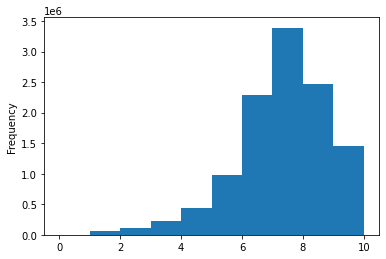

In [293]:
real_user_ratings_long_unscaled['Rating'].plot(kind='hist')

In [294]:
real_user_ratings_long_unscaled.describe()

,Rating
count,1.142426e+07
mean,6.957408e+00
std,1.593730e+00
min,1.401300e-45
25%,6.000000e+00
50%,7.000000e+00
75%,8.000000e+00
max,1.000000e+01


In [295]:
# We will use IQR to remove our outliers with the following function

def iqr_outliers(column, iqr_rate):
    """return the lower range and upper range for a column based on IQR*rate
    Inputs:
    column: the column to find iqr
    iqr_rate: iqr rate to determine lower and upper bounds
    
    Outputs:
    lower_range, upper_range: lower and upper bounds for column"""
    Q1,Q3 = np.percentile(column , [25,75]) # get the lower and upper quartiles
    iqr = Q3 - Q1 # find the interquartile range
    lower_range = Q1 - (iqr_rate * iqr) # find the lower range based on iqr rate
    upper_range = Q3 + (iqr_rate * iqr) # find the upper range based on iqr rate
    return lower_range,upper_range  

In [296]:
#lower, upper = iqr_outliers(real_user_ratings_long_scaled.Rating, 1.5)
#lower, upper

In [297]:
# dropping the things outside of our lower and upper range
#real_user_ratings_long_scaled.drop(real_user_ratings_long_scaled[ (real_user_ratings_long_scaled.Rating > upper) | (real_user_ratings_long_scaled.Rating < lower) ].index , inplace=True)

In [298]:
#real_user_ratings_long_scaled.describe()

##### Make Train/Val/Test Sets

In [299]:
# make train, val, test sets
train_real_ratings = real_user_ratings_long_unscaled[real_user_ratings_long_unscaled['UserID'].isin(train_users)]
val_real_ratings = real_user_ratings_long_unscaled[real_user_ratings_long_unscaled['UserID'].isin(val_users)]
test_real_ratings = real_user_ratings_long_unscaled[real_user_ratings_long_unscaled['UserID'].isin(test_users)]

In [300]:
# check shape of train and test sets
train_real_ratings.shape, val_real_ratings.shape, test_real_ratings.shape

((10297314, 3), (571644, 3), (555297, 3))

In [302]:
bottom = real_user_ratings_long_unscaled['Rating'].min()
top = real_user_ratings_long_unscaled['Rating'].max()

data_reader = Reader(rating_scale=(bottom, top))

data = Dataset.load_from_df(real_user_ratings_long_scaled[['UserID', 'BGGId', 'Rating']], data_reader)

In [303]:
del real_user_ratings_long_unscaled
gc.collect()

64

### Test Different Algorithms

In [304]:
benchmark = []

In [305]:
algorithms = [SVD(), 
              NormalPredictor(), 
              BaselineOnly(), 
             ]

# Iterate over all algorithms
for algorithm in algorithms:
    
    print("New Algorithm "+str(algorithm))
    
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=True)
    
    # Get results & append algorithm name
    results_df = pd.DataFrame.from_dict(results).mean(axis=0)
    results_df = results_df.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(results_df)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

New Algorithm <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x00000214C0607848>
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.2427  1.2418  1.2419  1.2421  0.0004  
Fit time          332.38  352.15  355.09  346.54  10.08   
Test time         25.67   22.63   117.67  55.32   44.11   
New Algorithm <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x0000020F0929F8C8>
Evaluating RMSE of algorithm NormalPredictor on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.4788  1.4793  1.4779  1.4787  0.0006  
Fit time          8.85    11.07   14.06   11.33   2.13    
Test time         22.16   188.56  25.21   78.64   77.74   
New Algorithm <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x0000020F0929FF88>
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE o

,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,1.200345,29.229640,87.493035
SVD,1.242119,346.542029,55.323785
NormalPredictor,1.478650,11.327609,78.643811


### Fit and Predict

In [306]:
# build a full trainset
trainset = data.build_full_trainset()

# build_testset() makes a test set out of the same trainset data (it is NOT an anti_testset)
testset = trainset.build_testset()

In [308]:
# Fit algorithm on trainset
algo = BaselineOnly()
algo.fit(trainset)

Estimating biases using als...


In [309]:
tests = algo.test(testset)

In [310]:
user_mean_lookup['moosh21']

{'user_mean': 5.991219512195122}

In [311]:
predictions_df = pd.DataFrame(tests)

In [332]:
user = 'moosh21'
item = 176189
user_mean = user_mean_lookup['moosh21']['user_mean']

In [333]:
user_df = predictions_df.loc[predictions_df['uid']==user]
user_df.head()

,uid,iid,r_ui,est,details
8766929,moosh21,223049,0.50878,1.401300e-45,{'was_impossible': False}
8766930,moosh21,102680,2.00878,1.202831e-01,{'was_impossible': False}
8766931,moosh21,150376,-1.99122,1.401300e-45,{'was_impossible': False}
8766932,moosh21,129437,0.50878,1.401300e-45,{'was_impossible': False}
8766933,moosh21,144239,0.00878,1.373323e-02,{'was_impossible': False}


In [334]:
user_df.loc[user_df['iid']==item]['est']+user_mean

8766939    6.142575
Name: est, dtype: float64

In [337]:
# predict on the validation dataset
prediction = algo.predict(uid='moosh21', iid=item, verbose=True)
prediction[3]+user_mean_lookup['moosh21']['user_mean']

user: moosh21    item: 176189     r_ui = None   est = 0.15   {'was_impossible': False}


6.142574967394993

In [336]:
real_user_ratings_dictionary_unscaled['moosh21']

{'4099': 6.0,
 '171011': 6.4,
 '143884': 6.5,
 '175117': 5.5,
 '13': 6.5,
 '224783': 4.5,
 '216092': 8.0,
 '31260': 6.0,
 '177697': 4.5,
 '173090': 6.3,
 '158243': 4.0,
 '100901': 5.3,
 '143401': 7.0,
 '194607': 4.5,
 '172081': 4.0,
 '181304': 7.7,
 '282171': 6.0,
 '176189': 8.5,
 '140863': 6.3,
 '194626': 7.3,
 '189506': 7.2,
 '162886': 4.0,
 '104006': 6.0,
 '131144': 5.0,
 '146508': 5.0,
 '262733': 10.0,
 '211534': 7.5,
 '142924': 6.0,
 '137297': 4.0,
 '160851': 6.0,
 '163413': 6.7,
 '248918': 5.5,
 '2653': 6.5,
 '175199': 5.5,
 '135779': 7.8,
 '146021': 6.5,
 '171623': 7.0,
 '128621': 7.3,
 '143986': 7.5,
 '180853': 5.8,
 '124': 6.0,
 '242302': 6.0,
 '150658': 5.0,
 '168584': 5.5,
 '63628': 6.9,
 '12942': 5.0,
 '200847': 5.5,
 '161936': 4.0,
 '174744': 6.8,
 '117914': 9.0,
 '164506': 5.0,
 '92828': 8.0,
 '203427': 6.3,
 '169124': 5.5,
 '202408': 5.0,
 '230059': 7.5,
 '172': 9.5,
 '155821': 8.0,
 '172207': 4.5,
 '123570': 6.0,
 '161970': 5.0,
 '158899': 8.0,
 '40628': 4.0,
 '103092':

In [111]:
val_data = Dataset.load_from_df(val_real_ratings[['UserID', 'BGGId', 'Rating']], data_reader)
val_set = val_data.build_full_trainset()

In [115]:
# make the antitrain set
val_test_set = val_set.build_testset()
anti_val_set = val_set.build_anti_testset()

In [ ]:
# predict on all items not predicted
unrated_val_predictions = algo.test(anti_val_set)

call predict on each item in actual user ratings

make validation trainset of REAL ratings only
make validation antitrainset


### TO DO Revert Predictions Transormations

* inverse_transform with the MinMaxScaler
* Add the mean for the BGGId

# Tests with Synthetic Data

In [54]:
# Opening JSON file
with open('synth_user_ratings_dictionary_scaled.json') as json_file:
    synth_user_ratings_dictionary_scaled = json.load(json_file)

In [55]:
# Opening JSON file
with open('real_user_ratings_dictionary_scaled.json') as json_file:
    real_user_ratings_dictionary_scaled = json.load(json_file)

In [61]:
# Opening JSON file
with open('synth_user_ratings_dictionary_unscaled.json') as json_file:
    synth_user_ratings_dictionary_unscaled = json.load(json_file)

In [62]:
# Opening JSON file
with open('real_user_ratings_dictionary_unscaled.json') as json_file:
    real_user_ratings_dictionary_unscaled = json.load(json_file)

##### Melted User Ratings

In [56]:
# load the real user ratings melted df
synth_user_ratings_long_scaled = pd.read_pickle('synth_user_ratings_long_scaled.pkl')
synth_user_ratings_long_scaled.head()

,UserID,BGGId,Rating
0,-Johnny-,1,1.706967
1,-Johnny-,2809,0.706967
2,-Johnny-,47185,1.706967
3,-Johnny-,104363,-0.293033
4,-Johnny-,3633,-2.293033


In [57]:
# check shape
synth_user_ratings_long_scaled.shape

(53062675, 3)

## Memory Based

### Finding Optimal v, k and n

In [38]:
vs_and_ks = []
mae_tracker = []
rmse_tracker = []

In [39]:
test_set = val_users[:250]

for v in [5, 10]:
    for k in [45, 60, 75, 90]:
        for n in [3, 4, 5]:
            start = time.time()
            string = 'v'+str(v)+'_k'+str(k)+'_n'+str(n)
            print("Calculating for "+string)
            global_mae, global_rmse, user_predictions_synth_basismemory = get_user_predictions(synth_user_ratings_dictionary_scaled, real_user_ratings_dictionary_scaled, test_set, v=v, k=k, n=n)
            vs_and_ks.append(string)
            mae_tracker.append(global_mae)
            rmse_tracker.append(global_rmse)
            end = time.time() - start
            print(str(end)+' elapsed\n')

Calculating for v5_k45_n3
MAE for set of users: 0.9530655047530753
RMSE for set of users: 1.2173850760414018
3097.840574979782 elapsed

Calculating for v5_k45_n4
MAE for set of users: 0.9465636198818939
RMSE for set of users: 1.2077091358517358
3083.331377506256 elapsed

Calculating for v5_k45_n5
MAE for set of users: 0.9436646095047186
RMSE for set of users: 1.2009156386286262
3111.9573917388916 elapsed

Calculating for v5_k60_n3


KeyboardInterrupt: 

In [40]:
zipped2 = list(zip(mae_tracker, rmse_tracker))
synth_scores = pd.DataFrame(zipped2, index=vs_and_ks, columns=['MAE', 'RMSE']).sort_values('RMSE')
synth_scores.to_pickle('synth_scores_v_k_n.pkl')
synth_scores

,MAE,RMSE
v5_k45_n5,0.943665,1.200916
v5_k45_n4,0.946564,1.207709
v5_k45_n3,0.953066,1.217385


### Get Val User Predictions

In [ ]:
# get distance between users and store in dict
user_predictions_synth_basismemory = {}

v, k, n =

global_mae, global_rmse, user_predictions_synth_basismemory = get_user_predictions(synth_user_ratings_dictionary_scaled, real_user_ratings_dictionary_scaled, val_users, v=v, k=k, n=n)

### Get Recommendations for a User

In [58]:
user = 'Threnody'

In [88]:
v, k, n = 10, 30, 2

In [93]:
synthetic_data = pd.DataFrame(synth_user_ratings_dictionary_unscaled[user].values(), index=synth_user_ratings_dictionary_unscaled[user].keys()).reset_index()
synthetic_data['index'] = synthetic_data['index'].astype('int32')
synthetic_data['Name'] = synthetic_data['index'].map(game_id_lookup)
synthetic_data.sort_values(0, ascending=True).head(20)

,index,0,Name
96,244521,1.000000,The Quacks of Quedlinburg
92,124708,2.000000,Mice and Mystics
89,233247,3.000000,Civilization: A New Dawn
140,17329,4.000000,Animal Upon Animal
167,271869,4.000000,Sushi Roll
90,155426,4.000000,Castles of Mad King Ludwig
158,195560,4.000000,Wasteland Express Delivery Service
180,111081,4.048071,Animal Upon Animal: Crest Climbers
184,315671,4.057812,Animal Upon Animal: Unicorns
201,84464,4.097123,Animal Upon Animal: Balancing Bridge


In [94]:
synthetic_data.sort_values(0, ascending=False).head(20)

,index,0,Name
0,246784,10.000000,Cryptid
146,463,10.000000,Magic: The Gathering
29,74,10.000000,Apples to Apples
112,174430,10.000000,Gloomhaven
113,163166,10.000000,One Night Ultimate Werewolf: Daybreak
117,2921,10.000000,The Game of Life
120,8051,10.000000,Attika
46,20100,10.000000,Wits & Wagers
16,201248,10.000000,Evolution: The Beginning
53,5782,10.000000,Coloretto


In [83]:
mae, rmse, this_user_predictions = get_user_predictions(synth_user_ratings_dictionary_scaled, real_user_ratings_dictionary_scaled, [user], v=v, k=k, n=n, scaled=True)

MAE for set of users: 0.8809828674898031
RMSE for set of users: 1.2223915297552146


In [84]:
predicted_items = list(this_user_predictions[user].keys())
actual_rated_items = list(real_user_ratings_dictionary_scaled[user].keys())

recommended_items = {}

recommendations_list = [item for item in predicted_items if item not in actual_rated_items]
recommendations_list

for item in recommendations_list:
    
    item_name = game_id_lookup[int(item)]
    recommended_items[item_name] = this_user_predictions[user][item]

In [85]:
user_mean_lookup[user]

{'user_mean': 7.222485207100592}

In [86]:
recommended_items

{'Gloomhaven: Jaws of the Lion': 7.222485207100592,
 'Twilight Imperium: Fourth Edition': 7.222485207100592,
 'Gaia Project': 7.222485207100592,
 'Star Wars: Rebellion': 7.222485207100592,
 'War of the Ring: Second Edition': 7.222485207100592,
 'Twilight Struggle': 7.378145584459082,
 '7 Wonders Duel': 7.222485207100592,
 'Terra Mystica': 7.222485207100592,
 'Brass: Lancashire': 7.222485207100592,
 'A Feast for Odin': 7.222485207100592,
 'Arkham Horror: The Card Game': 7.222485207100592,
 'Orléans': 7.222485207100592,
 'Root': 7.222485207100592,
 'Mage Knight Board Game': 7.222485207100592,
 'Dune: Imperium': 7.222485207100592,
 'Caverna: The Cave Farmers': 7.222485207100592,
 'Food Chain Magnate': 7.222485207100592,
 'Mansions of Madness: Second Edition': 7.222485207100592,
 'Lost Ruins of Arnak': 7.222485207100592,
 'Underwater Cities': 7.222485207100592,
 'Barrage': 7.222485207100592,
 'Anachrony': 7.222485207100592,
 "Tzolk'in: The Mayan Calendar": 7.222485207100592,
 'Kingdom Deat

In [87]:
pd.DataFrame(recommended_items.values(), index=recommended_items.keys(), columns=['Estimated Rating']).sort_values('Estimated Rating', ascending=False).head(30)

,Estimated Rating
Darkest December: Battle of the Bulge 1944,8.075288
Kawaguchi's Gamble: Edson's Ridge – The Battle for Guadalcanal,8.071587
Breakout: Normandy,7.878146
Monty's Gamble: Market Garden (Second Edition),7.864955
Mare Nostrum: War in the Mediterranean,7.853668
"Lilliburlero: The Battle of the Boyne, July 1690",7.852551
Love Letter: Batman,7.769330
Love Letter: The Hobbit – The Battle of the Five Armies,7.765503
Love Letter: Adventure Time,7.764463
Rise and Decline of the Third Reich,7.763366


## Model Based

Steps:

* Build trainset with all
* Fit to train set
* build trainset with VALIDATION group only
* Build anti-trainset with VALIDATION group only
* Predict on VALIIDATION trainset for metrics
* Predict on VALIIDATION anti-trainset for new
* Get accuracy metrics for actually rated
* Filter out actually rated and report on recommendations

* Hit Precision@k and recall@k ?

##### Melted User Ratings

In [86]:
# load the real user ratings melted df
synth_user_ratings_long_unscaled = pd.read_pickle('synth_user_ratings_long_unscaled.pkl')
synth_user_ratings_long_unscaled.head()

,UserID,BGGId,Rating
0,-Johnny-,1,1.706967
1,-Johnny-,2569,2.706967
2,-Johnny-,527,-1.293033
3,-Johnny-,55829,1.706967
4,-Johnny-,37400,-1.293033


In [87]:
synth_user_ratings_long_unscaled.loc[synth_user_ratings_long_unscaled['UserID']=='Threnody']

,UserID,BGGId,Rating
4536330,Threnody,199561,0.777515
4536331,Threnody,221194,0.777515
4536332,Threnody,116,-0.222485
4536333,Threnody,118063,0.777515
4536334,Threnody,244711,-0.722485
...,...,...,...
4536494,Threnody,232405,0.777515
4536495,Threnody,228341,-0.222485
4536496,Threnody,198994,-0.222485
4536497,Threnody,17223,0.777515


In [27]:
# check shape
synth_user_ratings_long_unscaled.shape

(11179216, 3)

In [72]:
#scaler = MinMaxScaler(feature_range=(1, 10))
#scaled_ratings = scaler.fit_transform(np.array(real_user_ratings_long['Rating']).reshape(-1,1))
#real_user_ratings_long['Rating'] = scaled_ratings
synth_user_ratings_long_unscaled.head()

,UserID,BGGId,Rating
0,-Johnny-,1,6.419345
1,-Johnny-,2569,6.926106
2,-Johnny-,527,4.899060
3,-Johnny-,55829,6.419345
4,-Johnny-,37400,4.899060


##### Make Train/Val/Test Sets

In [23]:
# make train, val, test sets
train_synth_ratings = synth_user_ratings_long_unscaled[synth_user_ratings_long_unscaled['UserID'].isin(train_users)]
val_synth_ratings = synth_user_ratings_long_unscaled[synth_user_ratings_long_unscaled['UserID'].isin(val_users)]
test_synth_ratings = synth_user_ratings_long_unscaled[synth_user_ratings_long_unscaled['UserID'].isin(test_users)]

In [24]:
# check shape of train and test sets
train_synth_ratings.shape, val_synth_ratings.shape, test_synth_ratings.shape

((10070365, 3), (560815, 3), (548036, 3))

In [ ]:
#scaler = MinMaxScaler(feature_range=(1, 10))
#scaled_ratings = scaler.fit_transform(np.array(synth_user_ratings_long_unscaled['Rating']).reshape(-1,1))
#synth_user_ratings_long['Rating'] = scaled_ratings
#synth_user_ratings_long.head()

In [ ]:
data_reader = Reader(rating_scale=(1, 10))

data = Dataset.load_from_df(synth_user_ratings_long_unscaled[['UserID', 'BGGId', 'Rating']], data_reader)

In [ ]:
del synth_user_ratings_long_unscaled
gc.collect()

In [ ]:
benchmark = []

In [ ]:
algorithms = [SVD(), 
              SlopeOne(), 
              NormalPredictor(), 
              BaselineOnly(), 
              CoClustering(),
             ]

# Iterate over all algorithms
for algorithm in algorithms:
    
    print("New Algorithm "+str(algorithm))
    
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=True)
    
    # Get results & append algorithm name
    results_df = pd.DataFrame.from_dict(results).mean(axis=0)
    results_df = results_df.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(results_df)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

In [ ]:
bsl_options = {'method': 'sgd'}

algorithms = [BaselineOnly(bsl_options=bsl_options)
             ]

# Iterate over all algorithms
for algorithm in algorithms:
    
    print("New Algorithm "+str(algorithm))
    
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    results_df = pd.DataFrame.from_dict(results).mean(axis=0)
    results_df = results_df.append(pd.Series(['Baseline_SGD'], index=['Algorithm']))
    benchmark.append(results_df)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

In [ ]:
# First fit on the dataset
trainset = data.build_full_trainset()
algo = BaselineOnly()
algo.fit(trainset)

In [ ]:
# scale transform the validation set ratings
scaled_ratings = scaler.transform(np.array(val_synth_ratings['Rating']).reshape(-1,1))
val_synth_ratings['Rating'] = scaled_ratings
val_synth_ratings.head()

In [ ]:
val_data = Dataset.load_from_df(val_synth_ratings[['UserID', 'BGGId', 'Rating']], data_reader)

val_set = val_data.build_full_trainset()

# predict on the validation dataset
rated_val_predictions = algo.predict(val_set)

# make the antitrain set 
anti_val_set = val_set.build_anti_testset()
# predict on all items not predicted
unrated_val_predictions = algo.predict(anti_val_set)

# Analysis

To Do: Which hybrid system am I using ?

# Future Work

##### Deployment

GUI to allow user to enter BGG user id, and provide list of recommendations

##### What if user has no BGG id or no rated items on BGG?

Cold-start survey is needed to pick up on some user basics in order to populate initial synthetic user matrix

    * Ask user what kinds of games they like - offer checkboxes
    * ask them to rate some of the top games in that category
    


Allow for the user to specify the things that are important to them

# Appendix

In [ ]:
break

# Deprecated

In [134]:
def get_user(user_matrix, user, game_ids, scaled=True):
    '''
    Takes in a sparse matrix of users and items, a specific user to retrieve, and a list of game_ids
    Get the mean for the user
    Builds a list of user's rated items and subtracts user mean from all ratings
    Builds a corresponding list of game ids for the rated games
    Gets intersection of user's rated ids with the overall game_ids
    Stores user game_id:rating in user ratings dictionary 
    Returns the user dictionary
    
    Inputs: 
    user_matrix: sparse matrix of users and game ratings
    user: user to retrieve
    game_ids: all possible game_ids in matrix
    
    Outputs:
    overall_user: user entry with user's game ratings
    user_mean: user's mean rating
    '''    
    # get the mean rating for that user
    user_mean = user_matrix[user].mean()
    
    if scaled:
    
        # normalize the ratings for that user by subtracting their mean from all ratings, store in list
        game_ratings = list(user_matrix.loc[user_matrix[user].notna()][user] - user_mean)
    
    else:
        game_ratings = list(user_matrix.loc[user_matrix[user].notna()][user])
    
    # Get a list of all of the game IDs that the user rated (meaning are not NaN)
    users_game_ids = list(user_matrix.loc[user_matrix[user].notna()][user].index)
    
    game_ids_set = set(game_ids).intersection(set(users_game_ids))
    
    # make a dictionary to store their ratings
    user_game_ratings = {}
    
    # for each matching key, value in game_ids and game_ratings for the user
    for key, value in zip(game_ids_set, game_ratings):
        # set as key: value in the game rating dict
        user_game_ratings[int(key)] = value
    
    # Make a dictionary to store the overall user
    overall_user = {}
      
    # store the user's ratings
    #overall_user['Ratings'] = user_game_ratings
    overall_user = user_game_ratings
    
    return overall_user, user_mean

In [133]:
def make_user_dictionaries(path_item, scaled=True):

    temp_dictionary = {}
    
    path = 'data_cleaned/ratings_matrix_cleaned_'+path_item+'.pkl'
    user_matrix = pd.read_pickle(path)
    user_matrix = user_matrix.T
    user_matrix.index = user_matrix.index.astype('int32')
    user_matrix.shape
    
    for user in user_matrix.columns:
    
        #print("Starting user "+user)
    
        # copy the current user dictionary to the synthetic ratings storage dictionary
        temp_dictionary[user], user_mean = get_user(user_matrix, user, game_ids, scaled)
        user_means[user] = user_mean
    
    return temp_dictionary, user_means